In [2]:
import numpy as np 
import pandas as pd 
import cv2
import os
import requests
from io import BytesIO

#視覺化
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
#import seaborn as sns  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, Input , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import model_selection, metrics, preprocessing
from tensorflow.python.keras.utils import np_utils

# model 混淆矩陣分析
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

In [6]:
#設定檔案路徑

TRAIN_DIR = r'C:\Users\young\Documents\AWINLAB\i.Deep Learning\dataset\train'
VAL_DIR = r'C:\Users\young\Documents\AWINLAB\i.Deep Learning\dataset\valid'
TEST_DIR = r'C:\Users\young\Documents\AWINLAB\i.Deep Learning\dataset\test'

#設定作業要求的指定類別
target_data = ["Airedale", "Beagle", "Bloodhound", "Bluetick", "Chihuahua", "Collie", "Dingo", "French Bulldog", "German Sheperd", "Malinois", "Newfoundland", "Pekinese", "Pomeranian", "Pug", "Vizsla"]

In [7]:
#刪除不必要的類別

# Set the path to the dataset
data_path = '/Users/young/Documents/AWINLAB新生作業/i.深度學習(Deep Learning)/dataset/train'

# Get a list of class names from the data path
class_names = sorted(os.listdir(data_path))

# Count the number of classes
num_classes = len(class_names)

for name in sorted(os.listdir(data_path)):
    flag = 0
    if(name == '.DS_Store'):
        continue
    for target_name in target_data:
        if(name == target_name):
            flag = 1
    if(flag == 0):
        shutil.rmtree('/Users/young/Documents/AWINLAB新生作業/i.深度學習(Deep Learning)/dataset/valid/' + name)

#Print the class names and the total number of classes
#print("Class Names: \n", class_names)
#print("Number of Classes:", num_classes)

FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: '/Users/young/Documents/AWINLAB新生作業/i.深度學習(Deep Learning)/dataset/train'

In [8]:
#將圖片的值縮放到0~1
data_gen = ImageDataGenerator(rescale=1/255)

In [9]:
#設定batch_size的參數
BATCH_SIZE = 32

#圖片大小
DIMS = (224,224)
IMG_SIZE = 224

#產出資料集
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=VAL_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 1714 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 150 images belonging to 15 classes.


In [10]:
#設定模型
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

In [11]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(15,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)
# checkpoint = ModelCheckpoint(filepath='/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [13]:
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=80, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/80


c:\Users\young\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 679ms/step - accuracy: 0.7527 - loss: 1.3566 - val_accuracy: 0.9453 - val_loss: 0.2016 - learning_rate: 0.0100
Epoch 2/80
 1/53 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.9375 - loss: 0.2742

c:\Users\young\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9375 - loss: 0.1397 - val_accuracy: 1.0000 - val_loss: 2.3808e-04 - learning_rate: 0.0100
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 608ms/step - accuracy: 0.9649 - loss: 0.1344 - val_accuracy: 0.9844 - val_loss: 0.0606 - learning_rate: 0.0100
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8438 - loss: 0.1424 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 0.0100
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.9691 - loss: 0.1072 - val_accuracy: 0.9453 - val_loss: 0.0857 - learning_rate: 0.0100
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9688 - loss: 0.0599 - val_accuracy: 1.0000 - val_loss: 0.0026 - learning_rate: 0.0100
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - accuracy: 0.9649 - loss: 0.1068 - val_accuracy: 0.9922 - val_loss: 0.0522 - learning_rate: 0.0100
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accurac

In [20]:
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=80, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/80


c:\Users\young\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - accuracy: 0.7843 - loss: 1.1147 - val_accuracy: 0.9844 - val_loss: 0.0267 - learning_rate: 0.0100
Epoch 2/80
 1/53 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.9375 - loss: 0.3293

c:\Users\young\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9375 - loss: 0.1678 - val_accuracy: 0.9545 - val_loss: 0.0299 - learning_rate: 0.0100
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.9728 - loss: 0.0994 - val_accuracy: 0.9844 - val_loss: 0.0303 - learning_rate: 0.0100
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9375 - loss: 0.0773 - val_accuracy: 1.0000 - val_loss: 0.0059 - learning_rate: 0.0100
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.9586 - loss: 0.1344 - val_accuracy: 0.9531 - val_loss: 0.1438 - learning_rate: 0.0100
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 4.7978e-06 - learning_rate: 0.0100
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 550ms/step - accuracy: 0.9726 - loss: 0.1078 - val_accuracy: 0.9922 - val_loss: 0.1041 - learning_rate: 0.0100
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9688 - loss: 0.0143 - val_accurac

In [14]:
loss_cnn, accuracy_cnn = model.evaluate(test_data)
loss_cnn = loss_cnn*100
accuracy_cnn = accuracy_cnn*100
print('Test loss:', loss_cnn)
print('Test accuracy:', accuracy_cnn)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 0.9869 - loss: 0.0585
Test loss: 3.213323652744293
Test accuracy: 99.33333396911621


In [16]:
loss_cnn, accuracy_cnn = model.evaluate(val_data)
loss_cnn = loss_cnn*100
accuracy_cnn = accuracy_cnn*100
print('Valid loss:', loss_cnn)
print('Valid accuracy:', accuracy_cnn)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - accuracy: 0.9943 - loss: 0.0254
Valid loss: 4.136985540390015
Valid accuracy: 98.66666793823242


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,422,031 (85.53 MB)

 Trainable params: 206,415 (806.31 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 412,832 (1.57 MB)

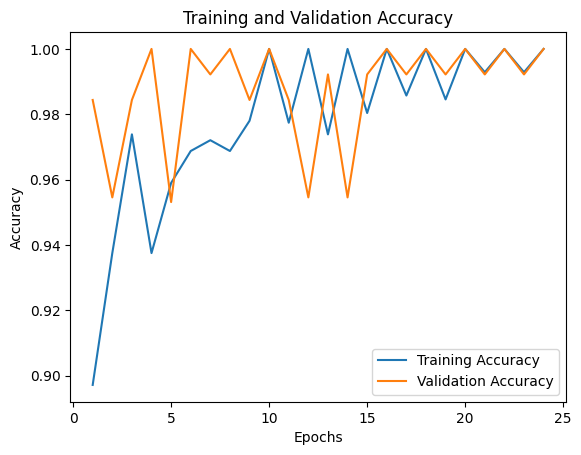

In [26]:
#繪製出精確度的圖表
train_acc = logs.history['accuracy']
val_acc = logs.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

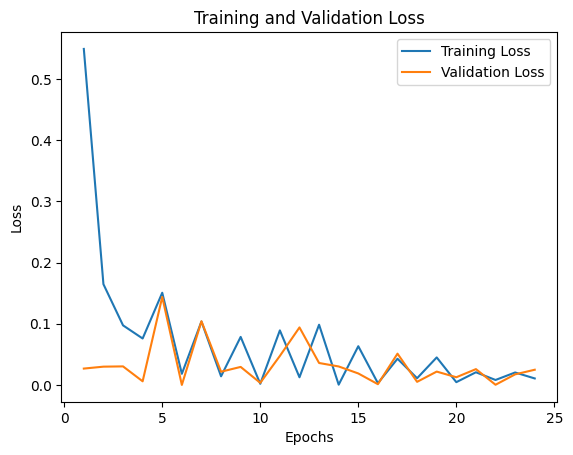

In [28]:
#繪製出loss的圖表
train_loss = logs.history['loss']
val_loss = logs.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

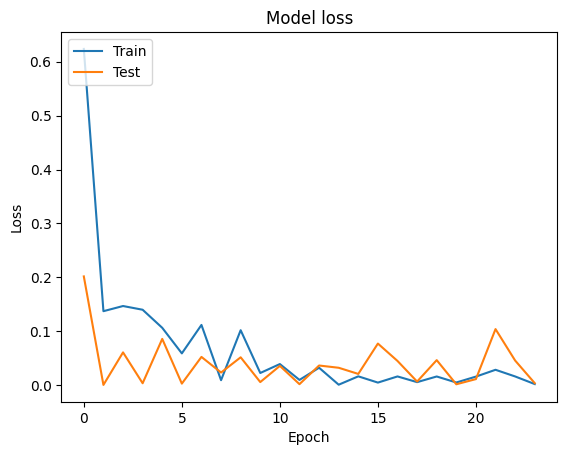

In [18]:
#train loss
plt.plot(logs.history['loss'])
#test loss
plt.plot(logs.history['val_loss'])
#標題
plt.title('Model loss')
#y軸標籤
plt.ylabel('Loss')
#x軸標籤
plt.xlabel('Epoch')
#顯示折線的名稱
plt.legend(['Train', 'Test'], loc='upper left')
#顯示折線圖
plt.show()

In [35]:
#對Testing set中的照片進行預測，並將結果寫入到test_data.xlsx

import openpyxl

wb = openpyxl.load_workbook(r'C:\Users\young\Documents\AWINLAB\i.Deep Learning\test_data.xlsx') 
s1 = wb['Sheet1']

#s1.cell(5,2).value = 100     # 儲存格 B1 內容 ( row=1, column=2 ) 為 100

# Set the path to the dataset
test_data_path = r'C:\Users\young\Documents\AWINLAB\i.Deep Learning\Testing set'

# Get a list of class names from the data path
img_names = sorted(os.listdir(test_data_path))

row = 2

for i in img_names:
    #print(i)
    if(i == ".DS_Store"):
        continue
    #print(j)
    test_img = test_data_path + "/" + i
    #print(test_img)
    img = image.load_img(test_img, target_size=(224, 224))
    img = image.img_to_array(img) # 灰階
    img = np.expand_dims(img, axis=0) # 轉換通道
    img = img/255 # rescale

    # 計算機率與預測結果
    pred = model.predict(img)[0]
    #print(pred) # 機率list
    index = np.argmax(pred)
    prediction = target_data[index]
    print(row-1,", prep:", prediction,) # 預測結果

    s1.cell(row, 1).value = i
    s1.cell(row, 2).value = prediction
    row = row + 1

wb.save(r'C:\Users\young\Documents\AWINLAB\i.Deep Learning\test_data.xlsx')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1 prep: French Bulldog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2 prep: German Sheperd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3 prep: Bloodhound
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4 prep: Chihuahua
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
5 prep: Vizsla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6 prep: Beagle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7 prep: Newfoundland
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8 prep: Pug
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
9 prep: French Bulldog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
10 prep: Beagle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
11 prep: Malinois
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
12 prep: Malinois
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
13 prep: Collie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
14 prep: Pomeranian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
15 prep: German Sheperd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
16 prep: Airedale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
17 prep: Collie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1

In [39]:
#對照標籤
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['Airedale', 'Beagle', 'Bloodhound', 'Bluetick', 'Chihuahua',
       'Collie', 'Dingo', 'French Bulldog', 'German Sheperd', 'Malinois',
       'Newfoundland', 'Pekinese', 'Pomeranian', 'Pug', 'Vizsla'],
      dtype='<U14')

In [49]:
#對單張照片進行預測
def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print("res.shape:", res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


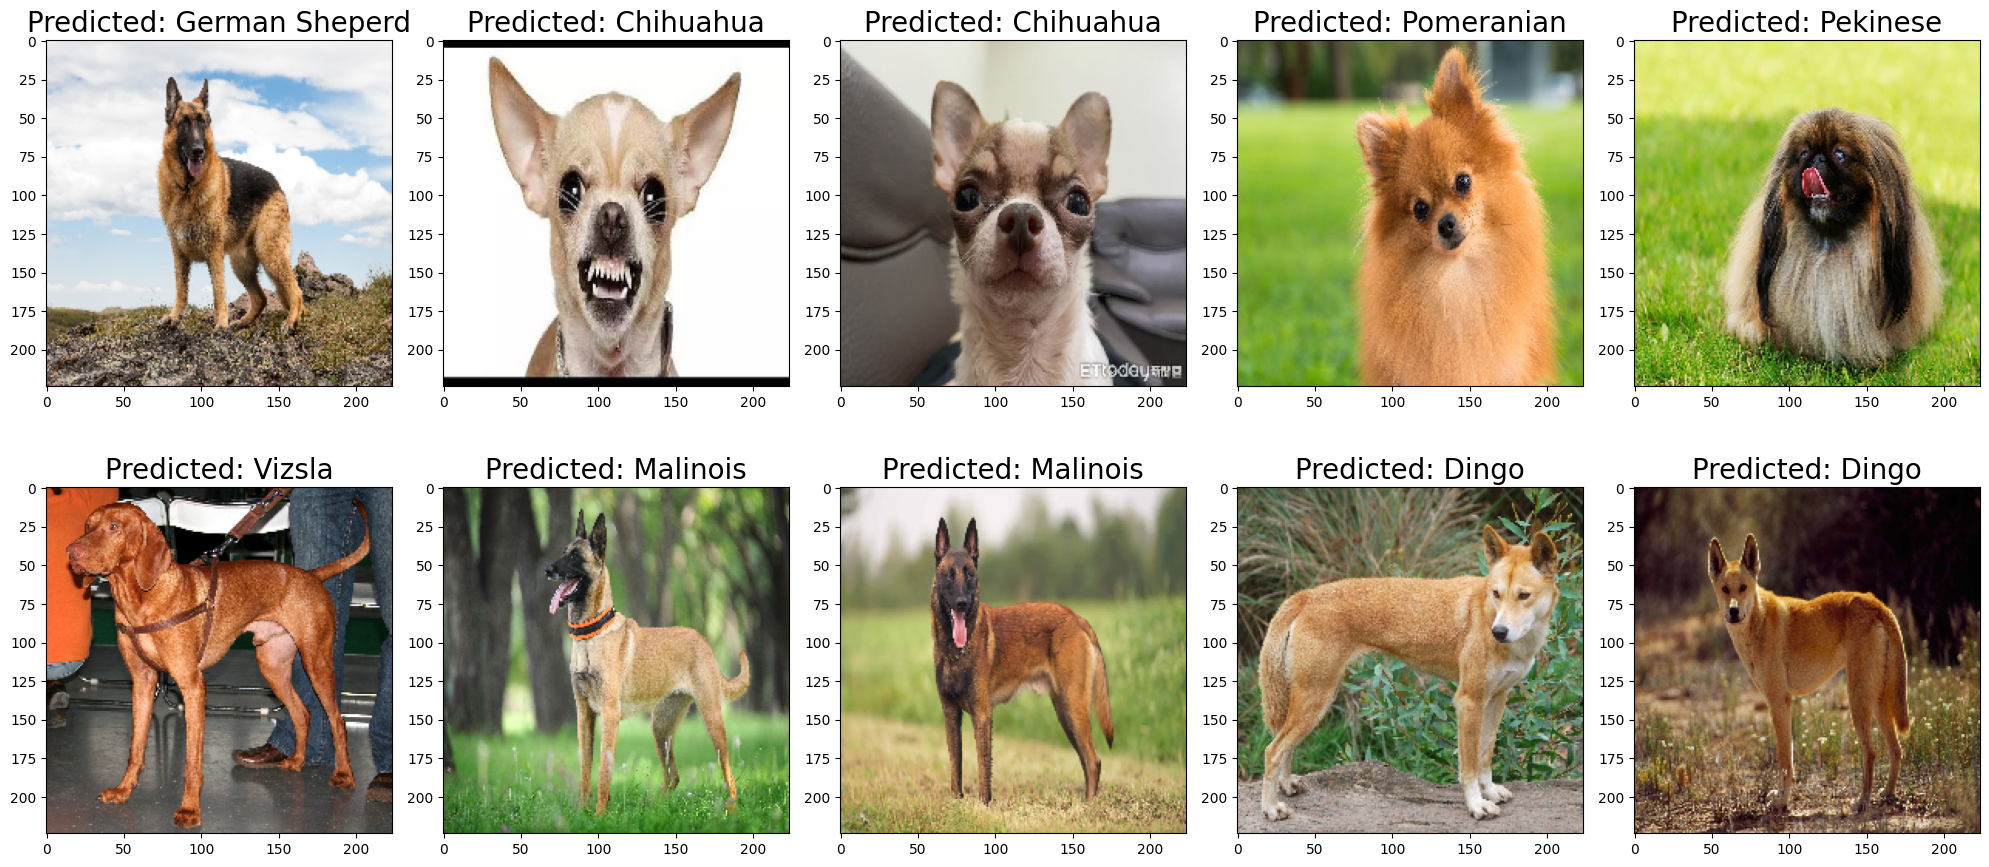

In [100]:
# 印出測試集隨機十筆預測後的結果和正解進行比較
url = [
    'https://www.google.com/url?sa=i&url=https%3A%2F%2Fencrypted-tbn3.gstatic.com%2Flicensed-image%3Fq%3Dtbn%3AANd9GcRv7Ev1T8O6as52YDwz3YDa9ya3-xv5SpMw3Lk_mZHqxwWvGDCw47ZaixFiTefWHF_dHHqDFFSYk2ZRKfU&psig=AOvVaw2brgj8mLWs5S3os1vdjdgh&ust=1690324655029000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCMDy4pa0qIADFQAAAAAdAAAAABAE',
    'https://images.chinatimes.com/newsphoto/2019-01-31/656/20190131001004.jpg',
    'https://cdn2.ettoday.net/images/7229/d7229507.jpg',
    'https://cdn.britannica.com/42/233842-050-E64243D7/Pomeranian-dog.jpg',
    'https://www.akc.org/wp-content/uploads/2017/11/Pekingese-standing-in-the-grass.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Wy%C5%BCe%C5%82_w%C4%99gierski_g%C5%82adkow%C5%82osy_500.jpg/1200px-Wy%C5%BCe%C5%82_w%C4%99gierski_g%C5%82adkow%C5%82osy_500.jpg',
    'https://cdn.britannica.com/85/232785-050-0EE871BE/Belgian-Malinois-dog.jpg',
    'https://dogsbestlife.com/wp-content/uploads/2019/11/Belgian-malinois-scaled.jpeg',
    'https://cdn.britannica.com/92/171292-050-AA6ABC3A/species-authorities-dingos-wolf-subspecies.jpg',
    'https://people.com/thmb/ZgAGcuEb7dooKyT9DygAo7XO7ZQ=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():focal(749x0:751x2)/dingo-040423-dec34a251fb444feb2001bfc23aa3542.jpg'
]
count=0
row=2
col=5
fig,ax=plt.subplots(row,col) # row=2 col=5
fig.set_size_inches(20,10)
for i in range (row):
    for j in range (col):
        response = requests.get(url[count])
        img = load_img(BytesIO(response.content), target_size=DIMS)
        
        arr = img_to_array(img)
        ax[i,j].imshow(img)
        arr = arr/255.0
        arr = np.expand_dims(arr,0)
        res = model.predict(arr)
        idx = res.argmax()
        ax[i,j].set_title("Predicted: "+label_mapper[idx], fontsize=20)
        plt.tight_layout()
        count+=1

In [48]:
# 模型結構存檔
from keras.models import model_from_json
json_string = model.to_json()
with open("cnn.config", "w") as text_file:
    text_file.write(json_string)

    
# 模型訓練結果存檔
model.save_weights("cnn.weights.h5")